# Import Library

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [194]:
dataset_path = 'dataset/'

# Lists to store data
file_names = []
labels = []
full_paths = []

for class_folder in sorted(os.listdir(dataset_path)):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            full_paths.append(os.path.join(class_folder_path, image_file))
            file_names.append(image_file)
            labels.append(class_folder) 



In [195]:
data = {
    'FileName': file_names,
    'ClassLabel': labels,
    'FullPath': full_paths
}
df = pd.DataFrame({"FileName": file_names, 'ClassLabel':labels, 'FullPath':full_paths})
df.groupby(['ClassLabel']).size()

ClassLabel
ayam           600
brokoli        600
ikan           600
kambing        600
kembang kol    600
kentang        600
kol            600
labu           600
mentimun       600
paprika        600
sapi           600
tahu           600
telur          600
tempe          600
tomat          600
udang          600
wortel         600
dtype: int64

In [196]:
df.head()

,FileName,ClassLabel,FullPath
0,ayam0.jpg,ayam,dataset/ayam\ayam0.jpg
1,ayam1.jpg,ayam,dataset/ayam\ayam1.jpg
2,ayam10.jpg,ayam,dataset/ayam\ayam10.jpg
3,ayam100.jpg,ayam,dataset/ayam\ayam100.jpg
4,ayam101.png,ayam,dataset/ayam\ayam101.png


In [197]:
x = df['FullPath'].values
y = df['ClassLabel'].values

# x adalah gambar dan y adalah label
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=300)

for train_index, temp_index in sss.split(x, y):
    X_train, X_temp = x[train_index], x[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=300)
for val_index, test_index in sss_temp.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


In [198]:
print(f"Training size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Training size: 7140
Validation size: 1530
Test size: 1530


In [199]:
X_train = X_train.astype(str)  
X_train = np.char.replace(X_train, "\\", "/")  
X_val = X_val.astype(str)  
X_val = np.char.replace(X_val, "\\", "/")  
X_test = X_test.astype(str)  
X_test = np.char.replace(X_test, "\\", "/") 

In [200]:
print(len(X_val))

1530


In [201]:
BATCH_SIZE = 32
EPOCH = 15
LABEL_MODE = 'categorical'
NUM_CLASSES = 17

# Image Preprocessing

In [456]:
# def ImagePreprocess1(image):
    
#     image = cv2.imread(image) 
#     img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
#     img_resize = cv2.resize(img_rgb, (300, 300))  # Resize to 300x300

#     kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
#     sharpened_image = cv2.filter2D(img_resize, -1, kernel)  # Apply sharpening filter
    
#     # Convert back to TensorFlow tensor
#     sharpened_image = tf.convert_to_tensor(sharpened_image, dtype=tf.float32)

#     return sharpened_image

# def ImagePreprocess1(image):
#     # Menggunakan TensorFlow untuk menggantikan OpenCV
#     img_rgb = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Convert image to float32
#     img_resize = tf.image.resize(img_rgb, (300, 300))  # Resize to 300x300
    
#     # Membuat filter penajaman (sharpening filter) menggunakan TensorFlow
#     kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
#     kernel = tf.convert_to_tensor(kernel, dtype=tf.float32)
#     sharpened_image = tf.nn.conv2d(tf.expand_dims(img_resize, axis=0), kernel[None, None, :, :], strides=[1, 1, 1, 1], padding="SAME")
#     sharpened_image = tf.squeeze(sharpened_image, axis=0)
    
#     return sharpened_image

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
])

def preprocess_image_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300, 300])  
    image = image / 255.0  
    image = data_augmentation(image)
    return image, label  

def preprocess_image_val(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300, 300])  
    image = image / 255.0  
    return image, label  

In [420]:
preprocessed_img_train = [ImagePreprocess1(path) for path in X_train]
X_train_preprocessed = np.array(preprocessed_img_train, dtype=np.float32)

preprocessed_img_val = [ImagePreprocess1(path) for path in X_val]
X_val_preprocessed = np.array(preprocessed_img_val, dtype=np.float32)

preprocessed_img_test = [ImagePreprocess1(path) for path in X_test]
X_test_preprocessed = np.array(preprocessed_img_test, dtype=np.float32)

AttributeError: image dtype must be either floating point or integer

In [457]:
def changeLabel(name):
    if name == "ayam":
        return 0
    elif name == "brokoli":
        return 1
    elif name == "ikan":
        return 2
    elif name == "kambing":
        return 3
    elif name == "kembang kol":
        return 4
    elif name == "kentang":
        return 5
    elif name == "kol":
        return 6
    elif name == "labu":
        return 7
    elif name == "mentimun":
        return 8
    elif name == "paprika":
        return 9
    elif name == "sapi":
        return 10
    elif name == "tahu":
        return 11
    elif name == "telur":
        return 12
    elif name == "tempe":
        return 13
    elif name == "tomat":
        return 14
    elif name == "udang":
        return 15
    elif name == "wortel":
        return 16


In [458]:
num_labels = to_categorical(np.array([changeLabel(i) for i in y_train], dtype=np.float32), num_classes=17)
val_labels = to_categorical(np.array([changeLabel(j) for j in y_val], dtype=np.float32), num_classes=17)
test_labels = to_categorical(np.array([changeLabel(k) for k in y_test], dtype=np.float32), num_classes=17)

In [459]:
print(X_train)

['dataset/tomat/tomat543.png' 'dataset/kembang kol/kembangkol348.png'
 'dataset/ikan/ikan421.jpg' ... 'dataset/paprika/paprika546.png'
 'dataset/ikan/ikan4521.png' 'dataset/sapi/sapi21.jpg']


In [460]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, num_labels))  
train_dataset = train_dataset.map(lambda x, y: preprocess_image_train(x, y), num_parallel_calls=tf.data.AUTOTUNE)  
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, val_labels))  
val_dataset = val_dataset.map(lambda x, y: preprocess_image_val(x, y), num_parallel_calls=tf.data.AUTOTUNE)  
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_labels))
test_dataset = test_dataset.map(lambda x, y: preprocess_image_val(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [461]:
print(test_dataset)
# print(val_labels)
# print(test_labels)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float32, name=None))>


In [462]:
model = Sequential([
      tf.keras.Input(shape=(300,300,3)),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(128, (3,3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D(2,2),
      Dropout(0.2),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(17, activation='softmax')
      ])

In [463]:
model.summary()

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_304 (Conv2D)         (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_304 (MaxPool  (None, 149, 149, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_305 (Conv2D)         (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_305 (MaxPool  (None, 73, 73, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_306 (Conv2D)         (None, 71, 71, 128)       73856     
                                                                 
 batch_normalization_74 (Ba  (None, 71, 71, 128)    

In [464]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [465]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/15
224/224 [==============================] - 338s 1s/step - loss: 1.7019 - accuracy: 0.4731 - val_loss: 2.3708 - val_accuracy: 0.4908
Epoch 2/15
224/224 [==============================] - 336s 1s/step - loss: 1.1857 - accuracy: 0.6043 - val_loss: 1.4658 - val_accuracy: 0.6752
Epoch 3/15
224/224 [==============================] - 341s 2s/step - loss: 1.0258 - accuracy: 0.6542 - val_loss: 1.2839 - val_accuracy: 0.5484
Epoch 4/15
224/224 [==============================] - 335s 1s/step - loss: 0.9324 - accuracy: 0.6924 - val_loss: 0.9495 - val_accuracy: 0.6889
Epoch 5/15
224/224 [==============================] - 331s 1s/step - loss: 0.8482 - accuracy: 0.7134 - val_loss: 0.9579 - val_accuracy: 0.6824
Epoch 6/15
224/224 [==============================] - 324s 1s/step - loss: 0.7812 - accuracy: 0.7308 - val_loss: 0.8483 - val_accuracy: 0.7242
Epoch 7/15
224/224 [==============================] - 327s 1s/step - loss: 0.7367 - accuracy: 0.7475 - val_loss: 0.9380 - val_accuracy: 0.7059

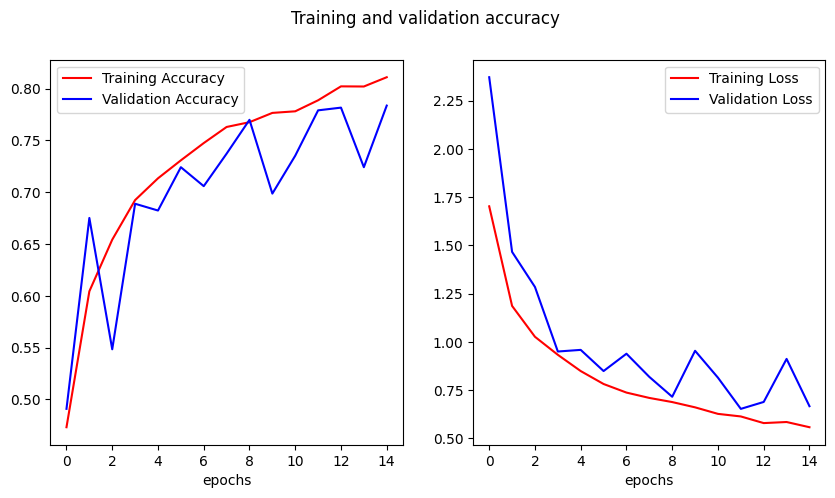

In [466]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(train_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(num_labels, y_pred_labels)